# Implementation of Freedman's GBM with Custom Objective

In this notebook, I figure out the hacks needed to implement Freedman's original GBM algorithm using sklearn DecisionTreeRegressor as the weak learner and scipy minimize as the argmin method.
Basically we just need to be able to modify the tree predictions to predict the best prediction value according to the argmin of the loss function.
This page on the [decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)  in the sklearn documentation is super helpful.

## sklearn decision trees

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [55]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 50)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

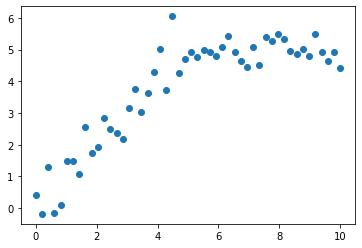

In [56]:
plt.plot(x, y, 'o')

In [57]:
reg = DecisionTreeRegressor(max_depth=2)
reg.fit(x, y)
y_hat = reg.predict(x)

In [58]:
# parallel arrays that give info on the nodes
pd.DataFrame({
    'children_left': reg.tree_.children_left
    , 'children_right': reg.tree_.children_right
    , 'feature': reg.tree_.feature 
    , 'threshold': reg.tree_.threshold
    , 'n_node_samples': reg.tree_.n_node_samples 
    , 'impurity': reg.tree_.impurity
})

,children_left,children_right,feature,threshold,n_node_samples,impurity
0,1,4,0,2.959184,50,2.849011
1,2,3,0,0.918367,15,0.950057
2,-1,-1,-2,-2.000000,5,0.296067
3,-1,-1,-2,-2.000000,10,0.286922
4,5,6,0,3.775510,35,0.414710
5,-1,-1,-2,-2.000000,4,0.093126
6,-1,-1,-2,-2.000000,31,0.193573


The index corresponds to the nodes in the tree.
`children_left` and `children_right` give the index of the left and right children of the given node. 
They are set to -1 on the terminal nodes.
Looks like the tree is indexed in a depth-first order.

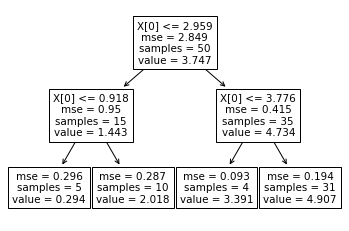

In [59]:
plot_tree(reg);

In [60]:
# find the terminal nodes that each observation lands in.
reg.apply(x)

array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6])

In [61]:
# find the terminal nodes that each observation lands in.
# it works on the tree_ object too
reg.tree_.apply(x.astype(np.float32))

array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6])

In [62]:
# terminal node id's
np.nonzero(reg.tree_.children_left == reg.tree_.children_right)[0]

array([2, 3, 5, 6])

In [63]:
# the prediction values for each node (including non terminal ones)
reg.tree_.value

array([[[3.74678515]],

       [[1.44346284]],

       [[0.29447461]],

       [[2.01795695]],

       [[4.73392329]],

       [[3.39124688]],

       [[4.90717185]]])

Not sure why `value` has two other dimensions.

In [64]:
# the prediction values for each node (including non terminal ones)
reg.tree_.value[:, 0, 0]

array([3.74678515, 1.44346284, 0.29447461, 2.01795695, 4.73392329,
       3.39124688, 4.90717185])

In [65]:
# manually get predicted values for given feature vector observations
reg.tree_.value[:, 0, 0][reg.apply(x)]

array([0.29447461, 0.29447461, 0.29447461, 0.29447461, 0.29447461,
       2.01795695, 2.01795695, 2.01795695, 2.01795695, 2.01795695,
       2.01795695, 2.01795695, 2.01795695, 2.01795695, 2.01795695,
       3.39124688, 3.39124688, 3.39124688, 3.39124688, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185])

In [66]:
# modifying one of the terminal node prediction values
reg.tree_.value[3, 0, 0] = 0.0

In [67]:
#built in predict method
reg.predict(x)

array([0.29447461, 0.29447461, 0.29447461, 0.29447461, 0.29447461,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       3.39124688, 3.39124688, 3.39124688, 3.39124688, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185,
       4.90717185, 4.90717185, 4.90717185, 4.90717185, 4.90717185])

## scipy minimize

In [68]:
from scipy.optimize import minimize

In [69]:
my_fun = lambda t: (t - 4)**2 + 3
t0 = 0
res = minimize(my_fun, t0)
res.x[0]

3.999999987147814

That wasn't so bad.

## Loss Function Classes

I think we'll implement loss functions as a class that the user supplies.
The class should have two methods, `loss` and `negative_gradient`, which both take two arguments, `y` and `y_hat`.
The `loss` method should return a scalar, while the `negative_gradient` method should return an array the same size as `y` and `y_hat`.

In [70]:
class SquaredErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean((y - y_hat)**2)
    
    def negative_gradient(self, y, y_hat):
        return y - y_hat

In [71]:
# make an instance
obj = SquaredErrorLoss()

In [72]:
# loss method should return a number
obj.loss(y, y_hat)

0.21445635962208243

In [73]:
# negative_gradient method should return an array, same shape as y and y_hat
obj.negative_gradient(y, y_hat)

array([ 0.12820511, -0.47602494,  0.99885698, -0.44311625, -0.20792091,
       -0.53908927, -0.52870239, -0.93625842,  0.52611945, -0.26261815,
       -0.07568407,  0.82995373,  0.48892624,  0.34728354,  0.15006935,
       -0.23822519,  0.36412946, -0.35895758,  0.2330533 , -0.61635731,
        0.12077706, -1.18812846,  1.14539973, -0.65160682, -0.2155968 ,
        0.02276012, -0.14019121,  0.09477109,  0.00239572, -0.09762186,
        0.1669505 ,  0.53049647,  0.00492825, -0.25137771, -0.45885752,
        0.18783254, -0.39167631,  0.50347454,  0.37940004,  0.57987462,
        0.43126587,  0.0585843 , -0.05168218,  0.10533927, -0.09567262,
        0.57327773,  0.02372125, -0.27711792,  0.0037559 , -0.49911829])

## GBM Implementation

In [74]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor 
from scipy.optimize import minimize

class GradientBoostingMachine():
    '''Gradient Boosting Machine supporting any user-supplied loss function.
    
    Parameters
    ----------
    n_trees : int
        number of boosting rounds
        
    learning_rate : float
        learning rate hyperparameter
        
    max_depth : int
        maximum tree depth
    '''
    
    def __init__(self, n_trees, learning_rate=0.1, max_depth=1):
        self.n_trees=n_trees; 
        self.learning_rate=learning_rate
        self.max_depth=max_depth;
    
    def fit(self, X, y, objective):
        '''Fit the GBM using the specified loss function.
        
        Parameters
        ----------
        X : ndarray of size (number observations, number features)
            design matrix
            
        y : ndarray of size (number observations,)
            target values
            
        objective : loss function class instance
            Class specifying the loss function for training.
            Should implement two methods:
                loss(labels: ndarray, predictions: ndarray) -> float
                negative_gradient(labels: ndarray, predictions: ndarray) -> ndarray
        '''
        
        self.trees = []
        self.base_prediction = self._get_optimal_base_value(y, objective.loss)
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        for _ in range(self.n_trees):
            pseudo_residuals = objective.negative_gradient(y, current_predictions)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, pseudo_residuals)
            self._update_terminal_nodes(tree, X, y, current_predictions, objective.loss)
            current_predictions += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
     
    def _get_optimal_base_value(self, y, loss):
        '''Find the optimal initial prediction for the base model.'''
        fun = lambda c: loss(y, c)
        c0 = y.mean()
        return minimize(fun=fun, x0=c0).x[0]
        
    def _update_terminal_nodes(self, tree, X, y, current_predictions, loss):
        '''Update the tree's predictions according to the loss function.'''
        # terminal node id's
        leaf_nodes = np.nonzero(tree.tree_.children_left == -1)[0]
        # compute leaf for each sample in ``X``.
        leaf_node_for_each_sample = tree.apply(X)
        for leaf in leaf_nodes:
            samples_in_this_leaf = np.where(leaf_node_for_each_sample == leaf)[0]
            y_in_leaf = y.take(samples_in_this_leaf, axis=0)
            preds_in_leaf = current_predictions.take(samples_in_this_leaf, axis=0)
            val = self._get_optimal_leaf_value(y_in_leaf, 
                                               preds_in_leaf,
                                               loss)
            tree.tree_.value[leaf, 0, 0] = val
            
    def _get_optimal_leaf_value(self, y, current_predictions, loss):
        '''Find the optimal prediction value for a given leaf.'''
        fun = lambda c: loss(y, current_predictions + c)
        c0 = y.mean()
        return minimize(fun=fun, x0=c0).x[0]
          
    def predict(self, X):
        '''Generate predictions for the given input data.'''
        return (self.base_prediction 
                + self.learning_rate 
                * np.sum([tree.predict(X) for tree in self.trees], axis=0))

### Mean Squared Error

In [75]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

In [76]:
class SquaredErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean((y - y_hat)**2)
    
    def negative_gradient(self, y, y_hat):
        return y - y_hat

In [77]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, SquaredErrorLoss())

Text(0.5, 1.0, 'model predicting mean or y | x')

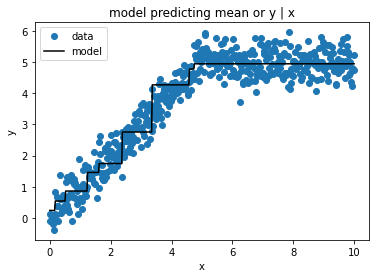

In [78]:
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o', label='data')
plt.plot(x.ravel(), gbm.predict(x), '-k', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting mean or y | x')

### Mean Absolute Error

In [79]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

In [80]:
class AbsoluteErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean(np.abs(y - y_hat))
    
    def negative_gradient(self, y, y_hat):
        return np.sign(y - y_hat)

In [81]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, AbsoluteErrorLoss())

Text(0.5, 1.0, 'model predicting median of y | x')

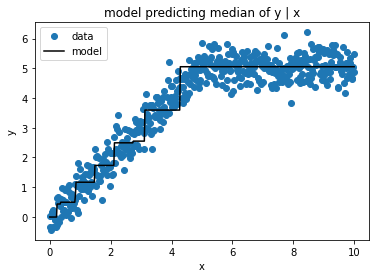

In [82]:
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o', label='data')
plt.plot(x.ravel(), gbm.predict(x), '-k', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting median of y | x')

### Quantile Loss

In [83]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
# y = np.where(x < 5, x, 5) + rng.uniform(-2, 2, size=x.shape)
y = np.where(x < 5, x, 5) + rng.normal(0, 1, size=x.shape)
x = x.reshape(-1,1)

In [84]:
class QuantileLoss():
    
    def __init__(self, alpha):
        if alpha < 0 or alpha >1:
            raise ValueError('alpha must be between 0 and 1')
        self.alpha = alpha
        
    def loss(self, y, y_hat):
        e = y - y_hat
        return np.mean(np.where(e > 0, self.alpha * e, (self.alpha - 1) * e))
    
    def negative_gradient(self, y, y_hat):
        e = y - y_hat 
        return np.where(e > 0, self.alpha, self.alpha - 1)

In [85]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, QuantileLoss(alpha=0.9))

Text(0.5, 1.0, 'model predicting 0.9 quantile of y | x')

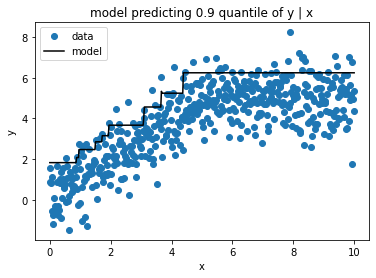

In [86]:
plt.plot(x, y, 'o', label='data')
plt.plot(x, gbm.predict(x), 'k-', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting 0.9 quantile of y | x')

### Binary Cross Entropy

In [87]:
rng = np.random.default_rng()
x = np.linspace(-3, 3, 500)
expit = lambda t: np.exp(t) / (1 + np.exp(t))
p = expit(x)
y = rng.binomial(1, p, size=p.shape)
x = x.reshape(-1,1)

In [88]:
class BinaryCrossEntropyLoss():
    # in these methods, y_hat gives the log odds ratio
    
    def __init__(self):
        self.expit = lambda t: np.exp(t) / (1 + np.exp(t))
    
    def loss(self, y, y_hat):
        p = self.expit(y_hat)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    def negative_gradient(self, y, y_hat):
        p = self.expit(y_hat)
        return y / p - (1 - y) / (1 - p)

In [89]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, BinaryCrossEntropyLoss())

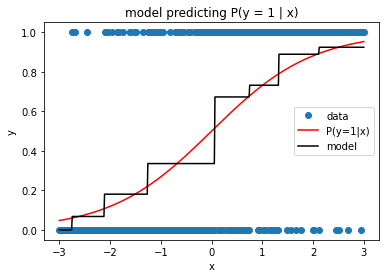

In [90]:
plt.plot(x, y, 'o', label='data')
plt.plot(x, p, '-r', label='P(y=1|x)')
plt.plot(x, expit(gbm.predict(x)), '-k', label='model')
plt.title('model predicting P(y = 1 | x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()